
- Most Quantum Cloud Services (QCS) users will want to use the Rigetti-hosted JupyterLab IDE to get a personal development environment with everything they need to get started. In some cases, users may choose to Install Locally. However, support for running from a local environment is limited.
- Installing locally is most useful for development using a Quantum Virtual Machine (QVM). Running programs against a QPU requires a reservation as well as network access to the QPU (available via your provisioned JupyterLab IDE).
- To make full use of pyQuil, you’ll want to have both the Quantum Virtual Machine (QVM) and the Quil Compiler (quilc) installed


## Version Information

<table align="left">
  <thead>
    <tr>
      <th>Component</th>
      <th>Version</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>python</td>
      <td>3.11.5</td>
    </tr>
    <tr>
      <td>pyquil</td>
      <td>4.10.0</td>
    </tr>
  </tbody>
</table>

</table>


In [34]:
import math
from pyquil import Program
from pyquil.gates import *
from pyquil.api import get_qc
import matplotlib.pyplot as plt
import networkx as nx
from pyquil.latex import to_latex, display, DiagramSettings

from sympy import isprime
import random
from fractions import Fraction
import numpy as np

from datetime import datetime
import numpy as np
import time


After install and activate docker on the machine, run the following commands:

- `docker run --rm -it -p 5555:5555 rigetti/quilc -P -S`

- `docker run --rm -it -p 5000:5000 rigetti/qvm -S`

In [35]:
from my_functions import *

In [36]:

def initiate_qc(N):
    n_len, m_len = get_nlen_mlen(N)
    qc = Program()
    for q in range(m_len):
        qc += H(q)
    qc += X(m_len)
    
    return qc

def append_c_amodN(qc, a, N):
    n_len, m_len = get_nlen_mlen(N)
    
    for q in range(m_len):
        pwr = 2 ** q
        for i, bit in enumerate(format(pow(a, pwr, N) ^ 1, f'0{n_len}b')):
            if bit == '1':
                qc += CNOT(q, i + m_len)
    return qc
    

def append_IQFT(qc, N):
    _, m_len = get_nlen_mlen(N)

    for q in range(m_len // 2):
        qc += SWAP(q, m_len - q - 1)
    
    # Apply QFT† gates
    for j in range(m_len):
        for m in range(j):
            angle = -np.pi / float(2 ** (j - m))
            qc += CPHASE(angle, m, j)
        qc += H(j)
    
    return qc


def simulation(qc, N, shots=1):
    n_len, m_len = get_nlen_mlen(N)
    total_qubits = n_len+m_len
    
    simulator = get_qc(f'{total_qubits}q-qvm')
    compiled_circuit = simulator.compile(qc)

    start_time = time.time()
    
#     result = simulator.run(compiled_circuit).readout_data
    result = simulator.run(compiled_circuit, trials=shots).get_register_map()
    
    # End timing
    end_time = time.time()
    
    print(f'## Duration(Simulation): {end_time - start_time:0.02f} sec')
    
    return [''.join(map(str, row))[::-1] for row in result['ro']]

# ro = "readout" as key of the result
def shor_qc(a, N):
    _, m_len = get_nlen_mlen(N)
    
    qc = initiate_qc(N)
    qc = append_c_amodN(qc, a, N)
    qc = append_IQFT(qc, N)
    
    # Measure the first m_len qubits
    ro = qc.declare('ro', 'BIT', m_len)
    for i in range(m_len):
        qc += MEASURE(i, ro[i])

    
    return qc


In [37]:
# import os

# if not ':/Library/TeX/texbin' in os.environ['PATH']
#     os.environ['PATH'] += ':/Library/TeX/texbin' 


In [40]:
# Example usage
N = 15
a = 7
qc = initiate_qc(N)
qc = append_c_amodN(qc, a, N)
# qc = append_IQFT(qc,N)

_, m_len = get_nlen_mlen(N)


# Measure the first m_len qubits
ro = qc.declare('ro', 'BIT', m_len)
for i in range(m_len):
    qc += MEASURE(i, ro[i])
    

# Print the result
print(simulation(qc, N))
# print('\n** The following digram without IQFT due to an error of drawing not in the circuit, limitation of the platform **')
# display(qc)

## Duration(Simulation): 0.28 sec
['00101011']


In [41]:
def test_shor_circuit(N, verbose=True, shots=1):
    def vprint(message):
        if verbose:
            print(message)

    FACTOR_FOUND = False
    ATTEMPT = 0

    # validate_N(N)  # no need to validate N value
    start_time = datetime.now()

    n_len, m_len = get_nlen_mlen(N)

    while not FACTOR_FOUND:
        ATTEMPT = 0
        for a in range(2,N):
            if math.gcd(a,N)==1:
                ATTEMPT += 1
                _txt = f'\n[a = {a}]'
                vprint(f"{_txt}\n{'-'*len(_txt)}")
                vprint(f"ATTEMPT {ATTEMPT}:")

                qc = shor_qc(a, N)
                readings = simulation(qc, N, shots=shots)
                
                two_power_mlen = 2**m_len

                for reading in readings:
                    int_reading = int(reading, 2)
                    vprint(f"\nRegister Reading: {reading} [{int_reading}]")
                    phase = int_reading/two_power_mlen
                    frac = Fraction(phase).limit_denominator(N)
                    r = frac.denominator
                    vprint(f"Corresponding Phase: [{int_reading}/{two_power_mlen}] >>> {phase:0.5f} >>> {frac}")

                    vprint(f"Result: r = {r}")

                    if not check_r_condition(a, r, N):
                        vprint(f"[{r}] did not pass r conditions")
                        continue

                    if phase != 0:
                        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
                        half_r = r//2
                        a_power_half_r = pow(a, half_r,N)
                        guesses = [math.gcd(a_power_half_r-1, N), math.gcd(a_power_half_r+1, N)]
                        vprint(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
                        for guess in guesses:
                            if guess not in [1,N] and (N % guess) == 0:
                                # Guess is a factor!
                                print(f"*** Non-trivial factor found: {guess} ***")
                                FACTOR_FOUND = True

                    if FACTOR_FOUND:
                        break

            else:
                vprint(f'\n# [a={a}] is not an accepted value! #')

            if FACTOR_FOUND:
                break

        if not FACTOR_FOUND:
            vprint('\nALL VALID A VALUES ARE USED !')
            FACTOR_FOUND = True



            # Record the end time
    end_time = datetime.now()

    # Calculate the duration
    duration = end_time - start_time
    # Format the duration to exclude microseconds
    formatted_duration = str(duration).split('.')[0]


    print(f"""
    ------------{'-'*len(str(ATTEMPT))}--
    # ATTEMPT = {ATTEMPT} #
    -------------{'-'*len(formatted_duration)}--
    # Duration = {formatted_duration} #
    -------------{'-'*len(formatted_duration)}--
    """)

    stop_flag_path = "stop_monitoring.flag"
    # Create the stop flag file
    with open(stop_flag_path, 'w') as f:
        f.write('stop')


# 1# N = 15 = 3 * 5

In [47]:
N = 15
test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 0.07 sec
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:00:03 #
    ----------------------
    


# 2# N = 35 = 5 * 7

In [43]:
N = 35
test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 1.49 sec
*** Non-trivial factor found: 5 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:00:13 #
    ----------------------
    


# 3# N = 77 = 7 * 11

In [46]:
N = 77
test_shor_circuit(N, verbose=False, shots=100)

## Duration(Simulation): 6.97 sec
*** Non-trivial factor found: 7 ***

    ---------------
    # ATTEMPT = 1 #
    ----------------------
    # Duration = 0:00:22 #
    ----------------------
    


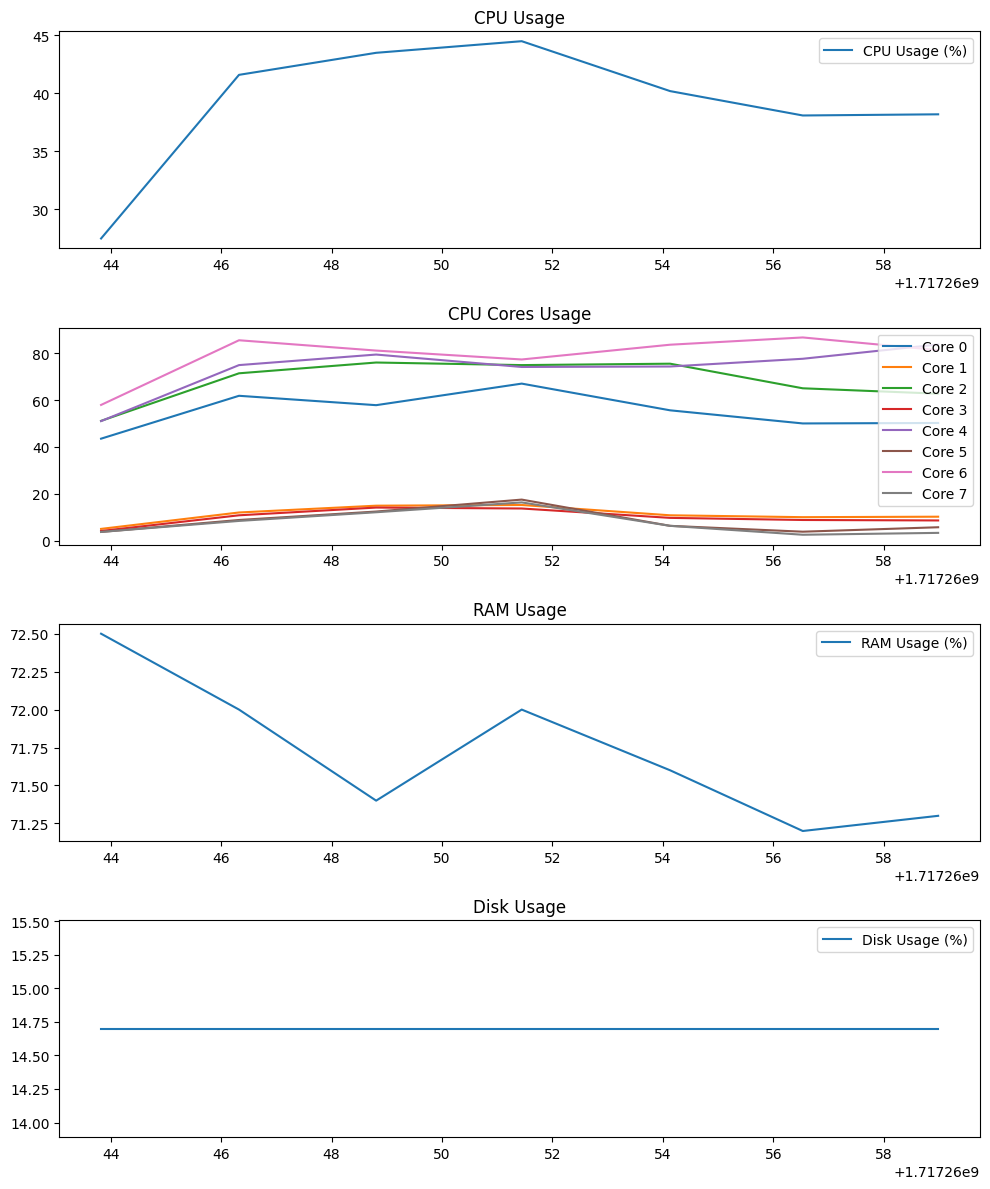

# 4# N = 143 = 11 * 13

In [48]:
N = 143
test_shor_circuit(N, verbose=False, shots=100)

QVMError: Could not communicate with QVM at http://127.0.0.1:5000

# 5# N = 221 = 13 * 17

# 6# N = 323 = 17 * 19

# 7# N = 437 = 19 * 23

# 8# N = 667 = 23 * 29